In [1]:

import numpy as np
from numpy import array
import random
from random import randint
import os
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from keras.optimizers import SGD
import io                      
import torch
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/dev-aadarsh/DeepAnT/master/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_60.csv',index_col=0)
data.head()



,value,is_anomaly
timestamp,,
1,1.265278,0
2,1.100833,0
3,1.147778,0
4,1.053889,0
5,1.051944,0


In [3]:

from pandas import read_csv
from matplotlib import pyplot

In [4]:
data.shape

(1461, 2)

In [5]:
train_percent = int(0.3*len(data))
valid_percent = int(0.1*len(data))
test_percent = int(0.6*len(data))


In [6]:



train_data = list(data.iloc[:train_percent,0])
valid_data = list(data.iloc[train_percent:train_percent+valid_percent,0])
test_data = list(data.iloc[train_percent+valid_percent:,0])



In [7]:
# define parameters
w = 35
pred_window = 1
filter1_size = 32
filter2_size = 32
kernel_size = 2
stride = 1
pool_size = 2

In [8]:
len(data)

1461

In [9]:
def get_subsequences(data):
    X = []
    Y = []
    
    for i in range(len(data) - w -pred_window):
        X.append(data[i:i+w])
        Y.append(data[i+w:i+w+pred_window])
    return np.array(X),np.array(Y)

trainX,trainY = get_subsequences(train_data)
print("trainx",trainX.shape)
print("trainy",trainY.shape)

trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))


validX,validY = get_subsequences(valid_data)
validX = np.reshape(validX,(validX.shape[0],1,validX.shape[1]))

testX,testY = get_subsequences(test_data)
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1]))

trainx (402, 35)
trainy (402, 1)


In [10]:
#  CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## layers of a CNN
        
        self.conv1 = nn.Conv1d(1,filter1_size,kernel_size,stride,padding = 0)
        
        self.conv2 = nn.Conv1d(filter1_size,filter2_size,kernel_size,stride,padding = 0)

        self.maxpool = nn.MaxPool1d(pool_size)
        
        self.dim1 = int(0.5*(0.5*(w-1)-1)) * filter2_size
        
        self.lin1 = nn.Linear(self.dim1,pred_window )
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        
        #convolution layer 1
        x = (F.relu(self.conv1(x)))
        x = self.maxpool(x)
        #print(x.shape)
        #x = self.dropout(x)

        #convolution layer 2
        x = (F.relu(self.conv2(x)))
        x = self.maxpool(x)
    

        
        x = x.view(-1,self.dim1) ## Flatten layer
        x = self.dropout(x) ## Dropout layers are important in training CNNs because they prevent overfitting on the training data.
        x = self.lin1(x) ## Dense layer
       
        
        return x

In [11]:

# define CNN model

model_A1 = Net()
print(model_A1)

Net(
  (conv1): Conv1d(1, 32, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [12]:
criterion_scratch = nn.L1Loss()
optimizer_scratch = optim.SGD(model_A1.parameters(), lr = 1e-5,weight_decay=1e-6)

In [13]:
# function for training the model (also checks on validation data)

def train_valid(n_epochs, trainX,trainY, validX,validY,model, optimizer, criterion,save_path,freq = 5):
    """returns trained model"""

    target_train = torch.tensor(trainY).type('torch.FloatTensor')
    data_train = torch.tensor(trainX).type('torch.FloatTensor')
    
    target_valid = torch.tensor(validY).type('torch.FloatTensor')
    data_valid = torch.tensor(validX).type('torch.FloatTensor')
    
    train_loss_min = np.Inf
    valid_loss_min = np.Inf
    last_valid_loss= 0
    
    for epoch in range(1, n_epochs+1):
        
        ###################
        # training the model #
        ###################
        model.train()

        #print(data.shape)


        optimizer.zero_grad()
        output = model(data_train)
        loss = criterion(output, target_train)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        
        ###################
        # Validation #
        ###################
        model.eval()
        output_valid = model(data_valid)
        
        loss_valid = criterion(output_valid, target_valid)
        valid_loss = loss_valid.item()
        if(valid_loss == last_valid_loss):
            print('problem')
            
        last_valid_loss = valid_loss
        if(epoch%freq == 0):
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ))
            
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model,output

In [14]:
type(model_A1)

__main__.Net

In [30]:
model_A1,out = train_valid(3000, trainX,trainY,validX,validY, model_A1, optimizer_scratch, 
                      criterion_scratch, 'sinwave_DeepAnT_2.h5',freq = 10)


Validation loss decreased (inf --> 0.906656).  Saving model ...
Validation loss decreased (0.906656 --> 0.906501).  Saving model ...
Validation loss decreased (0.906501 --> 0.906346).  Saving model ...
Validation loss decreased (0.906346 --> 0.906190).  Saving model ...
Validation loss decreased (0.906190 --> 0.906035).  Saving model ...
Validation loss decreased (0.906035 --> 0.905880).  Saving model ...
Validation loss decreased (0.905880 --> 0.905725).  Saving model ...
Validation loss decreased (0.905725 --> 0.905570).  Saving model ...
Validation loss decreased (0.905570 --> 0.905416).  Saving model ...
Epoch: 10 	Training Loss: 0.917063 	Validation Loss: 0.905262
Validation loss decreased (0.905416 --> 0.905262).  Saving model ...
Validation loss decreased (0.905262 --> 0.905108).  Saving model ...
Validation loss decreased (0.905108 --> 0.904953).  Saving model ...
Validation loss decreased (0.904953 --> 0.904799).  Saving model ...
Validation loss decreased (0.904799 --> 0.9046

In [31]:
model_A1.load_state_dict(torch.load('sinwave_DeepAnT_2.h5'))

<All keys matched successfully>

In [32]:
# make predictions

test_tensor =  torch.tensor(testX).type('torch.FloatTensor')
model_A1.eval()


Net(
  (conv1): Conv1d(1, 32, kernel_size=(2,), stride=(1,))
  (conv2): Conv1d(32, 32, kernel_size=(2,), stride=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [33]:
out = model_A1(test_tensor)
out = out.detach().numpy()

In [34]:

df_out = pd.DataFrame()
df_out['pred'] = out[:,0]
df_out['actual'] = testY[:,0]


In [35]:
# compute error (actual - pred)

df_out['error'] = np.abs(df_out['pred'] - df_out['actual'])
df_out['error_n'] = (df_out['error'] - df_out['error'].mean())/df_out['error'].std()
df_out.index = data.index[train_percent + valid_percent +w+pred_window-1:-1]
df_out.head()

,pred,actual,error,error_n
timestamp,,,,
620,0.493876,1.160000,0.666124,0.422680
621,0.497719,1.178333,0.680614,0.454401
622,0.501793,1.148889,0.647096,0.381025
623,0.510865,1.095556,0.584690,0.244408
624,0.523164,1.005833,0.482669,0.021068


In [36]:
# check whether error is more than the threshold

thresh = df_out.loc[df_out['error_n'].abs() > 3]
thresh

,pred,actual,error,error_n
timestamp,,,,
844,0.533232,3.982222,3.448990,6.514815
1208,0.627807,5.646111,5.018304,9.950292
1209,0.782389,10.452778,9.670389,20.134444
1210,0.911311,4.237778,3.326467,6.246593
1211,1.064602,3.192222,2.127621,3.622128
1457,0.591537,2.680556,2.089019,3.537622
1458,0.611888,3.063889,2.452001,4.332249


In [37]:
# calc TP, FN, FP, TN

positives = data.loc[df_out.index].loc[data.is_anomaly == 1].index
negatives = data.loc[df_out.index].loc[data.is_anomaly == 0].index
tp = []
fn = []
fp = []
tn = []
for p in positives:
    if p in thresh.index:
        tp.append(p)
    else:
        fn.append(p)

for n in negatives:
    if n in thresh.index:
        fp.append(n)
    else:
        tn.append(n)

In [38]:
# calc F-score

recall = len(tp)/(len(tp)+len(fn))
precision = len(tp)/(len(tp)+len(fp))
F_score = 2* recall*precision/(recall + precision)
F_score

0.7777777777777778

In [39]:
df_out['error'] = np.abs(df_out['pred'] - df_out['actual'])

In [40]:
df_out.loc[df_out['error'].abs() <0.5, 'anomaly'] = 0 
df_out.loc[df_out['error'].abs() >0.5, 'anomaly'] = 1 



In [41]:
df_out.head()

,pred,actual,error,error_n,anomaly
timestamp,,,,,
620,0.493876,1.160000,0.666124,0.422680,1.0
621,0.497719,1.178333,0.680614,0.454401,1.0
622,0.501793,1.148889,0.647096,0.381025,1.0
623,0.510865,1.095556,0.584690,0.244408,1.0
624,0.523164,1.005833,0.482669,0.021068,0.0


In [42]:
df_out[['pred','actual','error','anomaly']].groupby('anomaly').count()

,pred,actual,error
anomaly,,,
0.0,573,573,573
1.0,268,268,268


In [43]:

data[['is_anomaly','value']].groupby('is_anomaly').count()

,value
is_anomaly,
0,1445
1,16


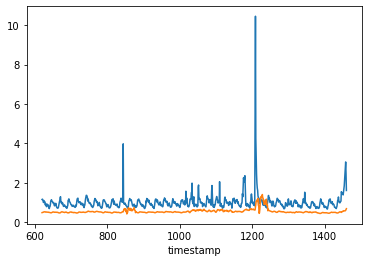

In [44]:
ax=df_out['actual'].plot()
df_out['pred'].plot(ax=ax)
plt.show()